<center>

*******************************************************************************************
<font size="4">
Cluster Phase &nbsp; &nbsp; <br>
<i>Rho</i> &nbsp; &nbsp; <br>
</font>

##### 23 September 2025

##### Juan Ignacio Mendoza Garay

*******************************************************************************************

</center>

##### INFORMATION:

* *Rho* is a measure of group synchrony.
>
* Tested with:
    * Python 3.11
    * Windows 11
    * [multiSyncPy](https://pypi.org/project/multiSyncPy/)
>
* References:
    * Frank, T. D., & Richardson, M. J. (2010). On a test statistic for the Kuramoto order parameter of synchronization: An illustration for group synchronization during rocking chairs. *Physica D: Nonlinear Phenomena, 239*(23-24), 2084-2092. https://doi.org/10.1016/j.physd.2010.07.015
    * Richardson, M. J., Garcia, R. L., Frank, T. D., Gergor, M., & Marsh, K. L. (2012). Measuring group synchrony: a cluster-phase method for analyzing multivariate movement time-series. *Frontiers in physiology, 3*, 405. https://doi.org/10.3389/fphys.2012.00405
    * https://github.com/cslab-hub/multiSyncPy
>
* Instructions:
    * Edit the values indicated with an arrow like this: <---

*******************************************************************************************

In [1]:
import sys
import numpy as np

sc_path = '../src'
sys.path.append(sc_path)
import syncoord as sc

***
### Generate synthetic data

index; key; Name; duration (s):
  0; 0; Test Data; 0:16.0


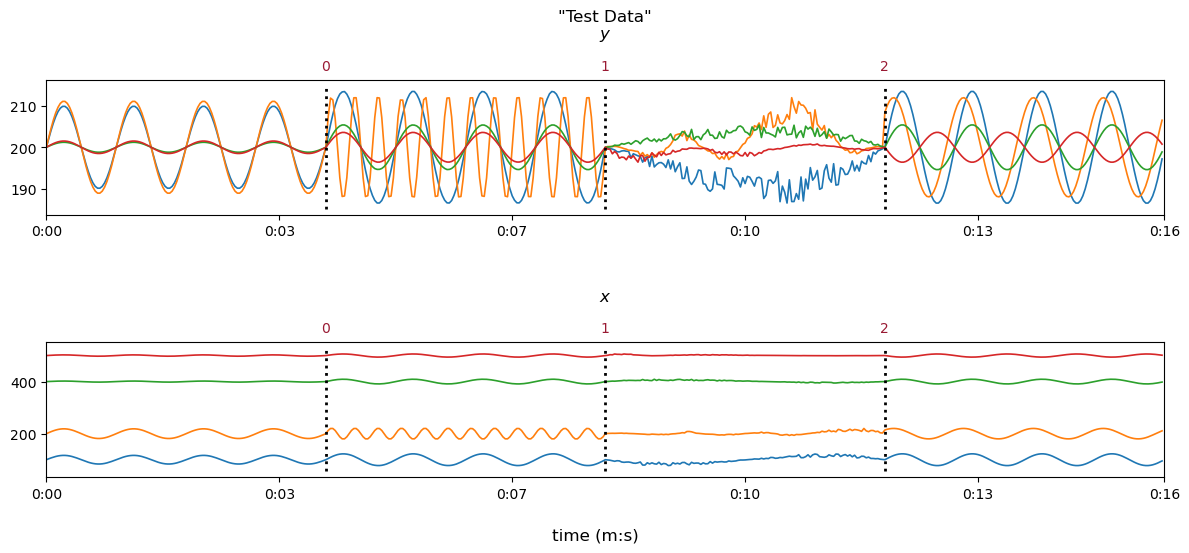

In [2]:
base_freq = 1     # <--- baseline frequency (Hz)
shuffseed = None  # <--- None = don't shuffle sections, int = shuffle sections
noise_fac = 0     # <--- noise strength for sections 0, 1, 3

testdata_vars = sc.utils.init_testdatavars(seed=1)
testdata_vars['point_vars'][[0,1,3],...,0] = base_freq
testdata_vars['point_vars'][1,1,...,0] = base_freq * 3
testdata_vars['point_vars'][...,5] = noise_fac
testdata_vars['point_vars'][2,...,5] = 0.5 # noise strength for section 2
if shuffseed is not None:
    rangen = np.random.default_rng(seed=shuffseed)
    rangen.shuffle(testdata_vars['point_vars'])
test_data_1 = sc.ptdata.load( testdata_vars, print_info=True )
test_data_1.visualise( vscale=1.2, dlattr='1.2' )

Unshuffled sections:
>0. All synchronised at baseline frequency, but signals 0 and 1 have higher amplitude.
>1. As in section 0, but signal 1 has triple the baseline frequency.
>2. Random oscillation.
>3. All have baseline frequency, but with constant phase differences: 1/8 cycle for signals 0 and 1; 1/2 cycle (*out of phase*) for signals 2 and 3.

Also each signal has distinct random noise.

***
### Low-Pass Filter

In [3]:
apply_LPF = False  # <--- Apply filter

filtparam = { 'filter_type' : 'savgol',         # <--- 'savgol' or 'butter'
               'window_size': 1/(4*base_freq),  # <--- if 'savgol': window size (seconds)
               'order' : 1 }                    # <--- filter's order

# filtparam = { 'filter_type' : 'butter',     # <--- 'savgol' or 'butter'
#               'freq_response' : 'lowpass',  # <--- if 'butter': frequency response
#               'cutoff_freq' : base_freq,    # <--- if 'butter': cutoff frequency (Hz)
#                'order' : 3 }                # <--- filter's order

if apply_LPF:
    test_data_2 = sc.ptdata.smooth( test_data_1, **filtparam )
    test_data_2.visualise( vscale=1.2, dlattr='1.2'  )
else:
    test_data_2 = test_data_1
    print('Low-pass filter not applied.')

Low-pass filter not applied.


***
### Reduce to 1 Dimension per point

Methods:
* Norms: the sum of the L1 and L2 norms preserve the shape of the oscillation and is not affected by noise.
* Speed: rectifies oscillation and is affected by noise, leading to artifacts when applying the Fourier Transform.

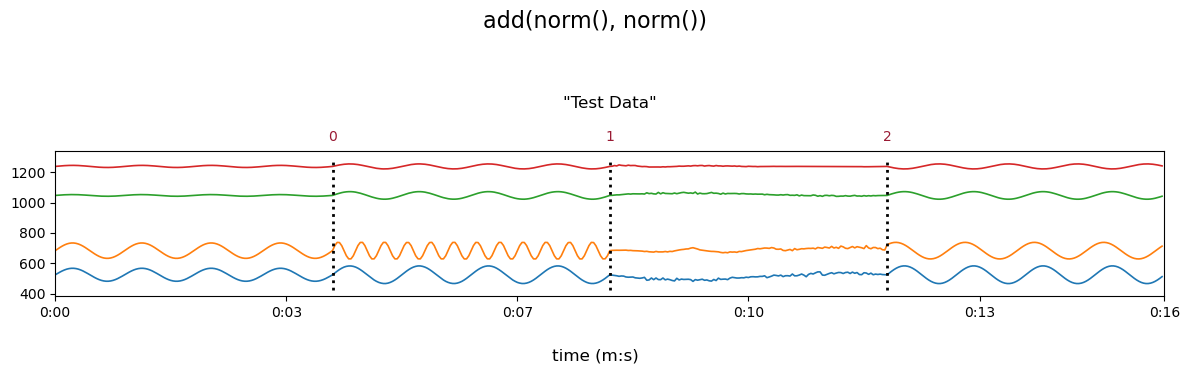

In [4]:
red1D_method = 'norms' # <--- 'norms' or 'speed'

if red1D_method == 'speed':
    test_data_3 = sc.ptdata.speed( test_data_2 )
elif red1D_method == 'norms':
    n1 = sc.ptdata.norm( test_data_2, order=1, axis=-2 )
    n2 = sc.ptdata.norm( test_data_2, order=2, axis=-2 )
    test_data_3 = sc.ptdata.apply2( n1, n2, np.add )
else: raise Exception('invaild value for red1D_method')
test_data_3.visualise( vscale=1.4, dlattr='1.2' )

***
### Phase

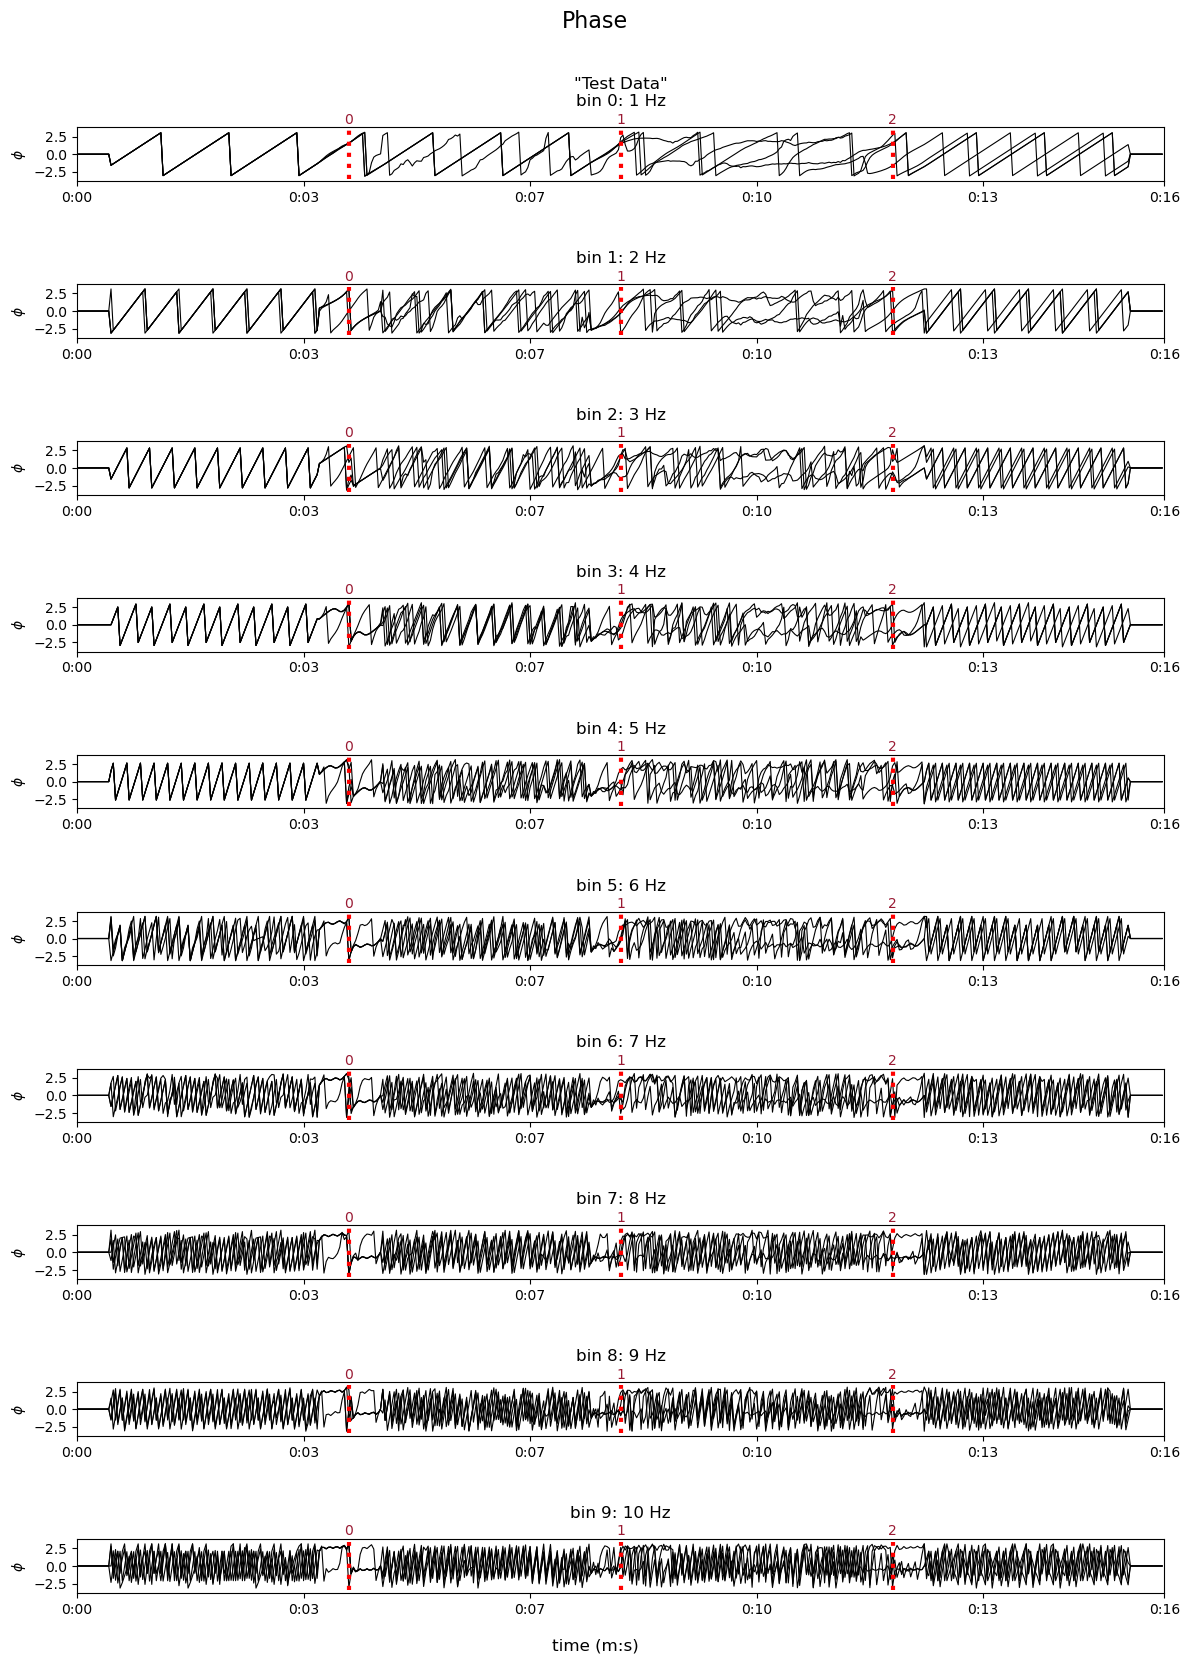

In [5]:
phase_method = 'FFT'            # <--- method for phase angles 'peaks' or 'FFT'
# phase_method = 'peaks'          # <--- method for phase angles 'peaks' or 'FFT'

if phase_method == 'peaks':

    min_dist = base_freq/2      # <--- minimum distance between peaks (seconds)

    phase = sc.ptdata.peaks_to_phase( test_data_3, fps=testdata_vars['fps'], min_dist=min_dist,
                                      endstart=True, height=0.2, prominence=0.1 )
    phase.visualise( groupby=-1, vscale=0.7 )
    margin = 1/(2*min_dist)

elif phase_method == 'FFT':

    fft_window_s = 1/base_freq  # <--- FFT window's length (seconds)
    sel_freq_bin = slice(0,10)  # <--- select frequency bins (int, slice, or 'all')
    # sel_freq_bin = 0            # <--- select frequency bins (int, slice, or 'all')

    phase = sc.ptdata.fourier( test_data_3, fft_window_s, output='phase' )
    if sel_freq_bin == 'all':
        phase.visualise( vscale=0.7 )
    else:
        phase = sc.ptdata.select(phase, frequency=sel_freq_bin)
        if isinstance(sel_freq_bin,slice): phase.visualise( vscale=0.7 )
        else: phase.visualise( vscale=1.3 )
    margin = fft_window_s

else: raise Exception('invalid value for phase_method')

***
### Cluster Phase

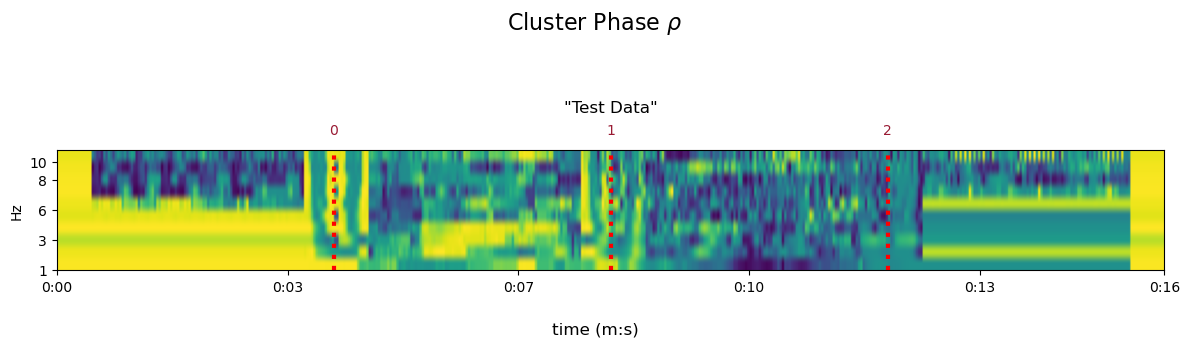

In [6]:
rho = sc.ptdata.rho( phase )
rho.visualise(vscale=1.3)

>
#### Band-average for group

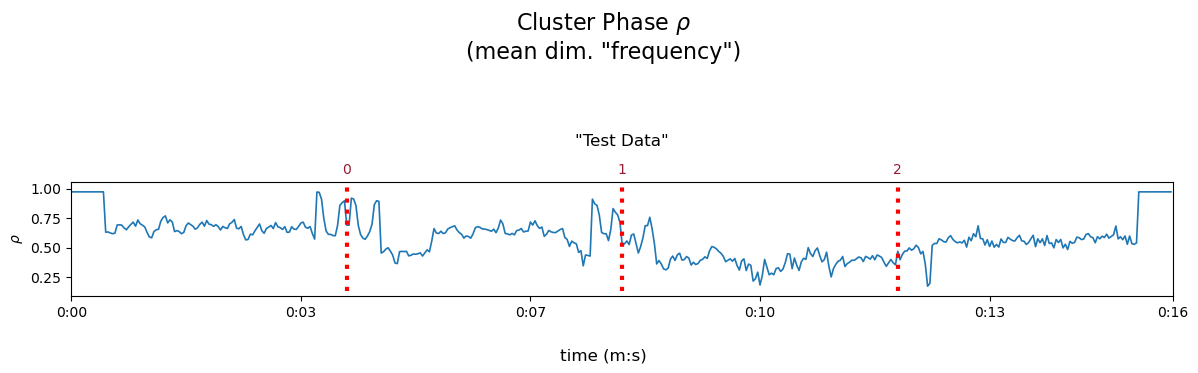

In [7]:
if isinstance(sel_freq_bin,int) or (phase_method == 'peaks'):
    rho_aggr  = rho
    print('Process does not apply.')
else:
    rho_aggr = sc.ptdata.aggrax( rho, axis=0, function='mean' )
    rho_aggr.visualise( vscale=1.3, vistype='line', dlattr='1.2' )

>
#### Sections' statistics

means = [0.671, 0.582, 0.381, 0.564]


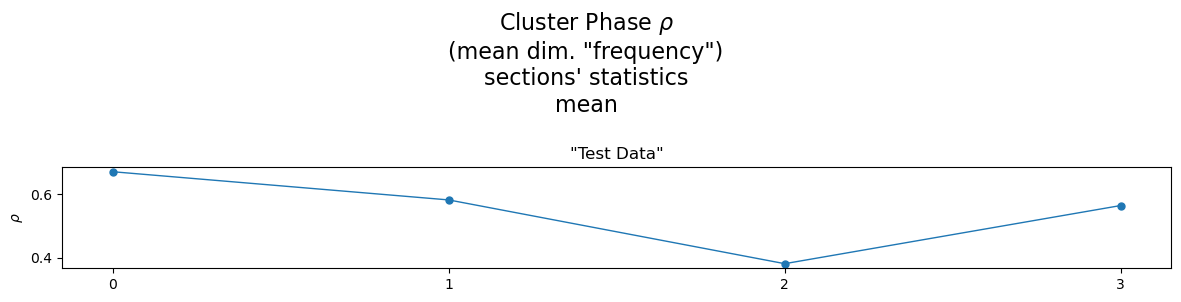

In [8]:
sec_margins = [[margin/2,margin/2] for _ in range(4)]
rho_aggr_stats = sc.ptdata.secstats( rho_aggr, margins=sec_margins, last=True )
rho_aggr_stats.visualise( statistics='mean' )
print('means =','['+', '.join([str(v) for v in np.round(rho_aggr_stats.data[0][0],3)])+']')